# Projeto - Previsão de receita

## Contexto:

**O contexto não foi definido**. Entretanto, para contextualizar o projeto **estarei adotando a seguinte abordagem:**

**Contexto:** Uma empresa chamada QualityShoes opera no ramo de e-commerce dentro da área de artigos esportivos. Como a empresa ainda não tem um time de dados estruturado, ela fez um contrato com uma empresa de consultoria especializada no ramo de transformação digital. Nesse sentido, após uma primeira reunião com o CFO da quality, a empresa de consultoria constatou que o primeiro projeto a ser realizado deveria ser a projeção de receita líquida. O portfólio da quality é bem amplo, com mais de 100 mil clientes atacadistas e varejistas. A ideia inicial do projeto é entender as principais variáveis que estão correlacionadas à receita e retirar insights importantes para o time de negócio.

## Objetivo de negócio:

* Projeção de receita para os próximos 6 meses

## Entendimento do negócio:

1. Qual a motivação:
    * A projeção de receita nos próximos 6 meses surgiu a partir da necessidade de entender qual o melhor budget para investimentos na empresa e também entender quais seriam as áreas que deveriam ter um melhor investimento.


2. Qual a causa raíz do problema:
    * Dificuldade em determinar o melhor budget para investimentos internos


3. Quem é o dono do problema:
    * Diretor financeiro (CFO) da QualityShoes


4. Qual é o formato da solução?
    * **Granularidade:** Previsão de receita diária nos próximos 183 dias (6 meses)
    * **Tipo de problema:** Previsão de receita (Regressão)
    * **Potenciais métodos:** Séries temporais e regressão com algumas modificações
    * **Formato de entrega:**
        * O valor total da receita líquida no final dos 6 meses.
        * A entrega será pelo app do streamlit
        * Checagem trimestral


# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import pathlib
import datetime



from IPython.core.display  import HTML
from IPython.display       import Image


In [2]:
import warnings
warnings.filterwarnings("ignore")

## 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

In [4]:
def _extract_letter(text):
    text = re.sub('[A-Z]','',text)
    return text


## 0.2 Variables path

In [5]:
PATH_ROOT = pathlib.Path('..').resolve()
DATA_ROOT = os.path.join(PATH_ROOT,'data')
DATA_RAW = os.path.join(DATA_ROOT,'raw')
DATA_PREPROCESSED = os.path.join(DATA_RAW, 'preprocessed')

DOC_ROOT = os.path.join(PATH_ROOT, 'doc')
IMAGE_PATH = os.path.join(DOC_ROOT,'image')
# File data
_data_raw = os.path.join(DATA_RAW, 'Dataset_teste_Just_BI.csv')
_image_map_hypothesis = os.path.join(IMAGE_PATH,'map_hypothesis.png')


## 0.3 Data Loading

In [6]:
df = pd.read_csv(_data_raw, sep=';')

# 1.0 Data Description

In [7]:
df1 = df.copy()

In [8]:
df1.head()

,customer_id,customer_acquisition_channel,year,week,net_revenue,gross_revenue,boxes
0,206461,Paid Marketing,2014,W09,71,71,2
1,462640,Paid Marketing,2015,W25,28,56,1
2,666461,Referral,2015,W50,40,40,1
3,183202,Referral,2013,W42,18,37,1
4,410993,Referral,2014,W29,0,37,1


## 1.1 Data info General

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715875 entries, 0 to 715874
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   customer_id                   715875 non-null  int64 
 1   customer_acquisition_channel  715875 non-null  object
 2   year                          715875 non-null  int64 
 3   week                          715875 non-null  object
 4   net_revenue                   715875 non-null  int64 
 5   gross_revenue                 715875 non-null  int64 
 6   boxes                         715875 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 38.2+ MB


Atributos:
- Id do Cliente
- Canal de aquisição do cliente
- Ano da venda
- Semana da venda
- Receita líquida
- Receita bruta
- Caixas

Obs: Não temos dados faltantes

## 1.2 Check NA

In [10]:
# Percentual dos dados faltantes
(df1.isna().sum() / len(df1))*100

customer_id                     0.0
customer_acquisition_channel    0.0
year                            0.0
week                            0.0
net_revenue                     0.0
gross_revenue                   0.0
boxes                           0.0
dtype: float64

## 1.3 Descriptive Statistics

### Change DTypes

In [11]:
# Extraindo os números da semana
df1['week_num'] = df1['week'].apply(_extract_letter)

In [12]:
df1['week_num']=df1['week_num'].astype('int64')
df1['net_revenue']= df1['net_revenue'].astype('float64')
df1['gross_revenue'] = df1['gross_revenue'].astype('float64')

In [13]:
numerical_attributes = df1.select_dtypes(include=['int64','float64'])
categorical_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64'])

### 1.3.1 Numerical Attributes

In [14]:
numerical_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,715875.0,323664.862498,186136.720066,103.0,159325.0,289541.0,476431.0,746721.0
year,715875.0,2014.196999,0.754568,2013.0,2014.0,2014.0,2015.0,2015.0
net_revenue,715875.0,36.415437,13.646022,0.0,37.0,37.0,37.0,532.0
gross_revenue,715875.0,41.430585,9.752502,14.0,37.0,37.0,40.0,532.0
boxes,715875.0,1.034697,0.190199,1.0,1.0,1.0,1.0,17.0
week_num,715875.0,27.491899,15.105624,1.0,14.0,28.0,41.0,53.0


In [15]:
# Central Tendency - Mean, Median (Métricas que resume a representatividade dos dados)
# Dispersion - std, min, max, range, skew, kurtosis (Medidas de dispersão em relação a média)
# skew : Como é a deformação da distribuição em relação a normal, se a deformação for mais para a direita teremos uma skew positiva, se for mais para a esquerda teremos uma skew negativa.
# Kurtosis: Métrica em relação a concentração dos dados, quanto maior a Curtose positiva, maior será o pico de concentração dos dados. Entretanto, quanto menor a Curtose, mais dispersos serão os dados, achatando ainda mais minha curva de distribuição.
skew = pd.DataFrame(numerical_attributes.apply( lambda x: x.skew() ))
kurtosis = pd.DataFrame(numerical_attributes.apply( lambda x: x.kurtosis() ))
range = pd.DataFrame(numerical_attributes.apply( lambda x: x.max() - x.min() ))
describe = pd.DataFrame(numerical_attributes.describe()).T
describe['range'] = range
describe['skew'] = skew
describe['kurtosis'] = kurtosis
describe = describe.reset_index()
describe = describe.rename(columns={'index':'Attributes'})
describe

,Attributes,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
0,customer_id,715875.0,323664.862498,186136.720066,103.0,159325.0,289541.0,476431.0,746721.0,746618.0,0.403586,-1.048270
1,year,715875.0,2014.196999,0.754568,2013.0,2014.0,2014.0,2015.0,2015.0,2.0,-0.342490,-1.179912
2,net_revenue,715875.0,36.415437,13.646022,0.0,37.0,37.0,37.0,532.0,532.0,0.526808,10.403764
3,gross_revenue,715875.0,41.430585,9.752502,14.0,37.0,37.0,40.0,532.0,518.0,3.435058,36.807084
4,boxes,715875.0,1.034697,0.190199,1.0,1.0,1.0,1.0,17.0,16.0,6.621214,112.525487
5,week_num,715875.0,27.491899,15.105624,1.0,14.0,28.0,41.0,53.0,52.0,-0.061525,-1.238845


<AxesSubplot:xlabel='net_revenue', ylabel='Density'>

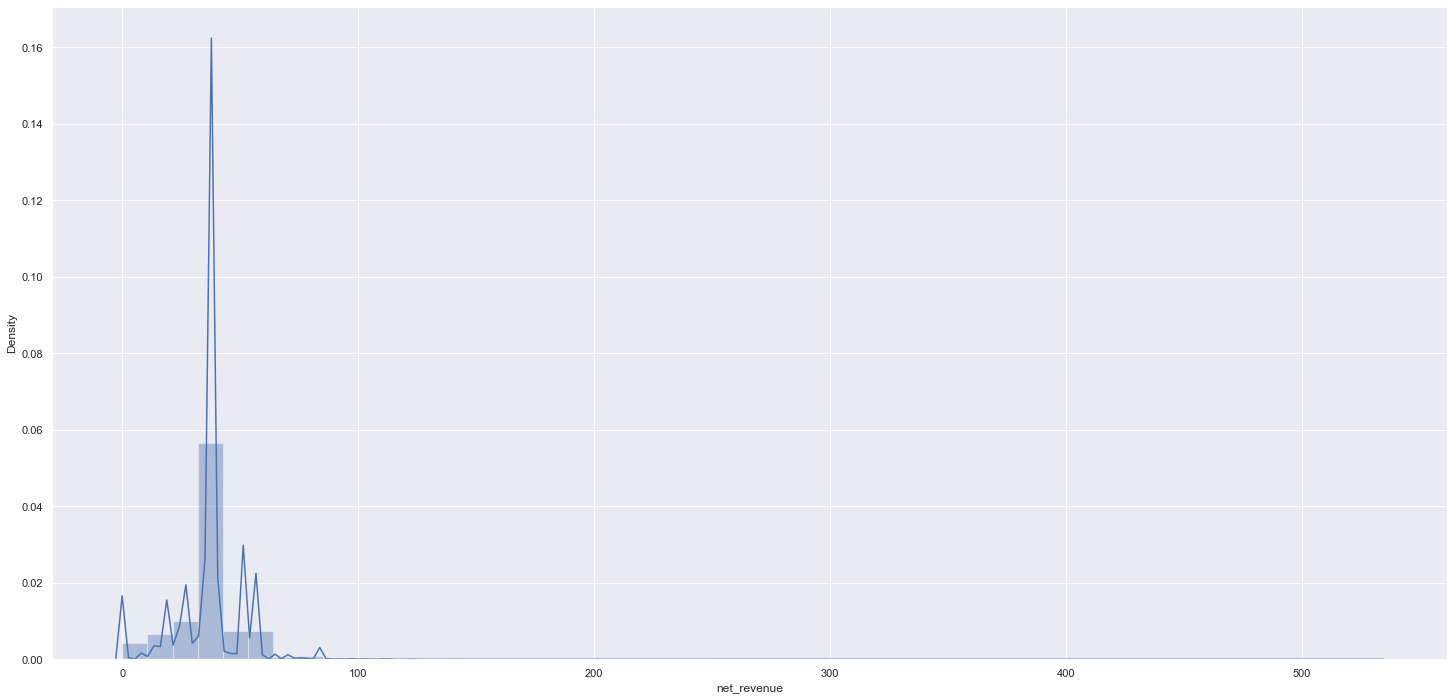

In [16]:
sns.distplot(df1['net_revenue'])

### 1.3.2 Categorical Attributes

In [17]:
categorical_attributes['boxes'] = numerical_attributes['boxes']
categorical_attributes = categorical_attributes.drop(['week'], axis=1)
#categorical_attributes.apply(lambda x: x.unique().shape[0])

<AxesSubplot:xlabel='boxes', ylabel='net_revenue'>

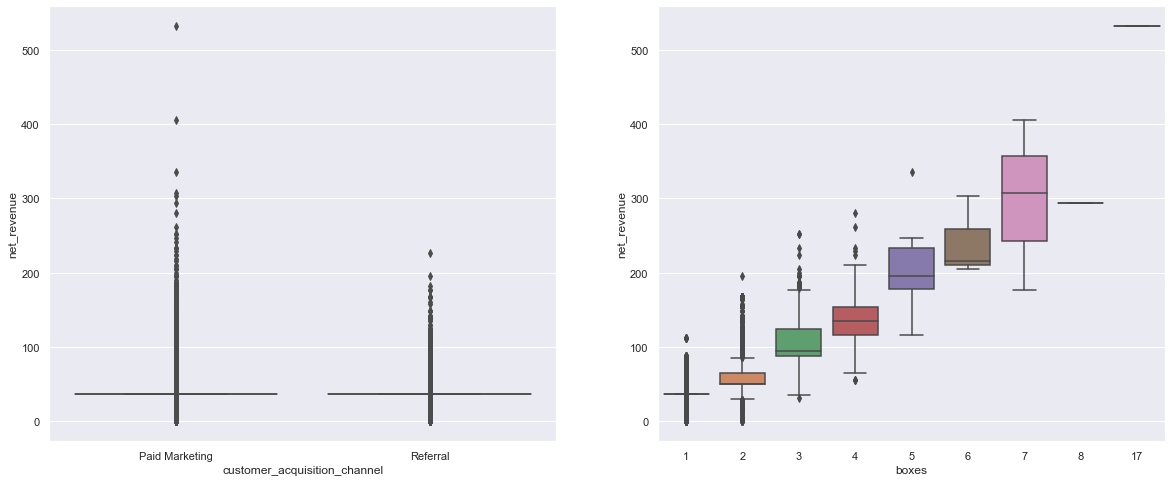

In [18]:
plt.figure(figsize = [20,8])
plt.subplot(1,2,1)
sns.boxplot(x='customer_acquisition_channel' , y= 'net_revenue' , data= df1)

plt.subplot(1,2,2)
sns.boxplot(x='boxes' , y= 'net_revenue' , data= df1)



Obs:
- Ao comparar os tipos de canal para aquisição dos clientes é perceptível que o marketing pago tem levemente uma distribuição de receita líquida mais favorecida que o canal de referências. Mas vale ressaltar que isso vale apenas para pontos extremos (Outliers), a média são equivalentes entre os dois tipos de acordo com o boxplot.

- O Box 7 tem uma melhor arrecadação de receita líquida quando comparado com os demais boxes (Exceto o box 17, mas como não existe uma boa variância, pode ser algo já previsível na receita). Além de não apresentar outliers, a média do box 7 está acima da mediana, então considera-se que temos um bom desempenho de arrecadação de receita líquida para esse box.

# 2.0 Feature Engineering

In [19]:
df2 = df1.copy()

## 2.1 Mind Map Hypothesis

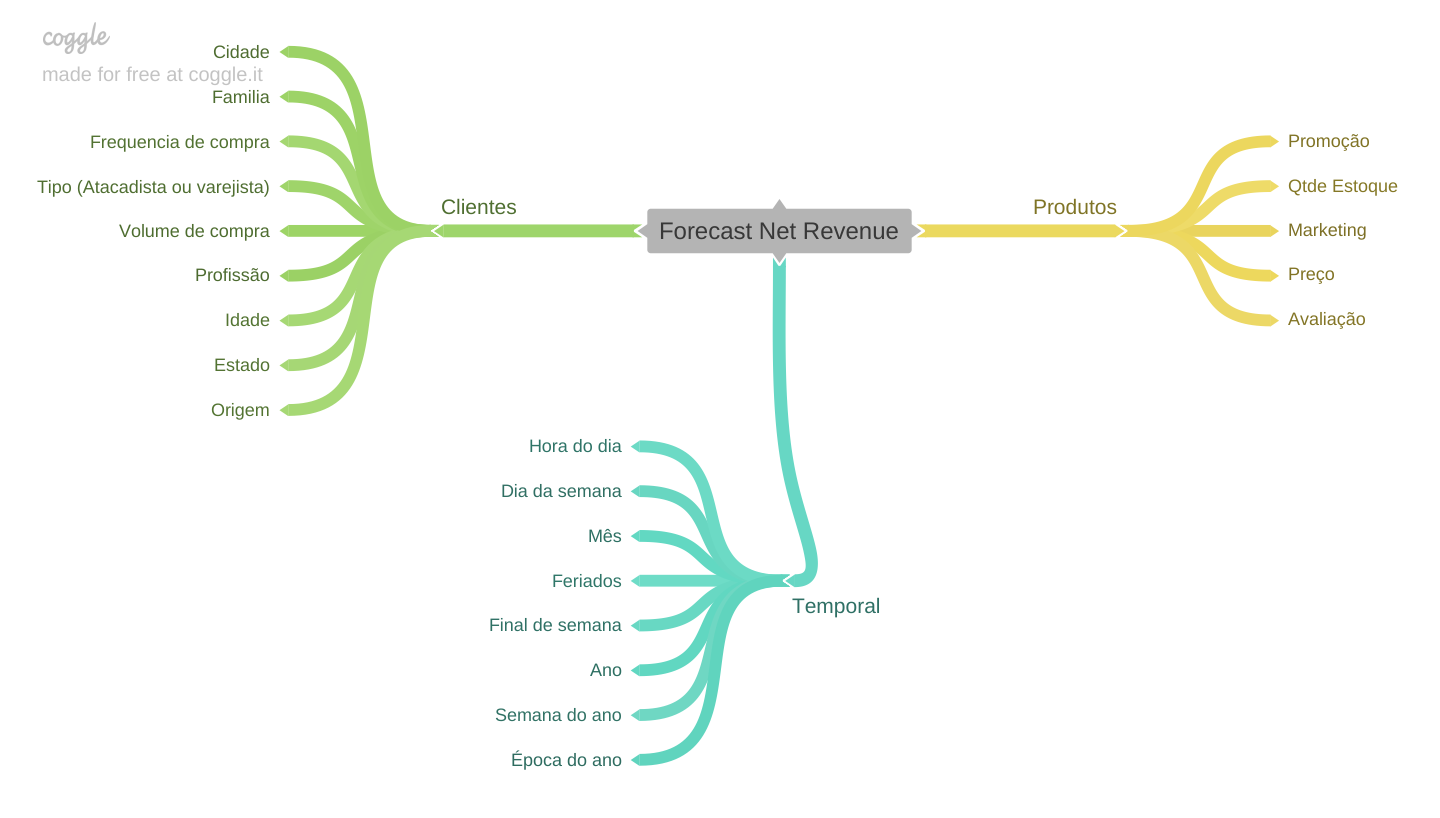

In [20]:
Image(_image_map_hypothesis)

## 2.2 Create Hypothesis

## 2.3 Feature Engineering

In [21]:
# Substituindo W53 por W52 e considerando que os anos tenham apenas 52 semanas e o mês 4 semanas normais.
df2['week'] = df2['week'].str.replace('W53','W52')

# Obtendo o campo data considerando que para cada semana do ano, o dia da semana adotado será segunda-feira.
df2['weekofyear'] = df2.apply(lambda x: str(x['year'])+'-'+x['week'], axis=1)
df2['date'] = df2.apply(lambda x: datetime.datetime.strptime(x['weekofyear']+ '-1', "%Y-W%W-%w" ), axis=1)

#Month
df2['month'] = df2['date'].dt.month

# Deduções: Impostos, despesas, cancelamentos e etc...

df2['deductions'] = df2['gross_revenue'] - df2['net_revenue']

# 3.0 Filtering variables

Nessa etapa estaremos filtrando as variáveis que não se adequam ao modelo em produção ou alguns registros que podem não fazer sentido.

In [22]:
df3 = df2.copy()

In [23]:
df3.head(3).T


,0,1,2
customer_id,206461,462640,666461
customer_acquisition_channel,Paid Marketing,Paid Marketing,Referral
year,2014,2015,2015
week,W09,W25,W50
net_revenue,71.0,28.0,40.0
gross_revenue,71.0,56.0,40.0
boxes,2,1,1
week_num,9,25,50
weekofyear,2014-W09,2015-W25,2015-W50
date,2014-03-03 00:00:00,2015-06-22 00:00:00,2015-12-14 00:00:00


**Não há nenhuma variável que possa ter algum tipo de restrição relacionado ao tipo de negócio**.
E em relação ao filtro de registros pode-se observar na seção 1.3.1 Numerical Attributes que não há valores negativos ou algum registro que esteja fora da normalidade.


# 4.0 Exploratory Data Analysis - EDA

**Como as variáveis impactam o fenômeno? e qual a força desse impacto?**

- Quais insigths podem ser retirados?

In [24]:
df4 = df3.copy()

In [25]:
num_attributes = df4.select_dtypes(include=['int64','float64'])
cat_attributes = df4.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

## 4.1 Análise Univariada

### 4.1.1 Target Variable

<AxesSubplot:xlabel='net_revenue'>

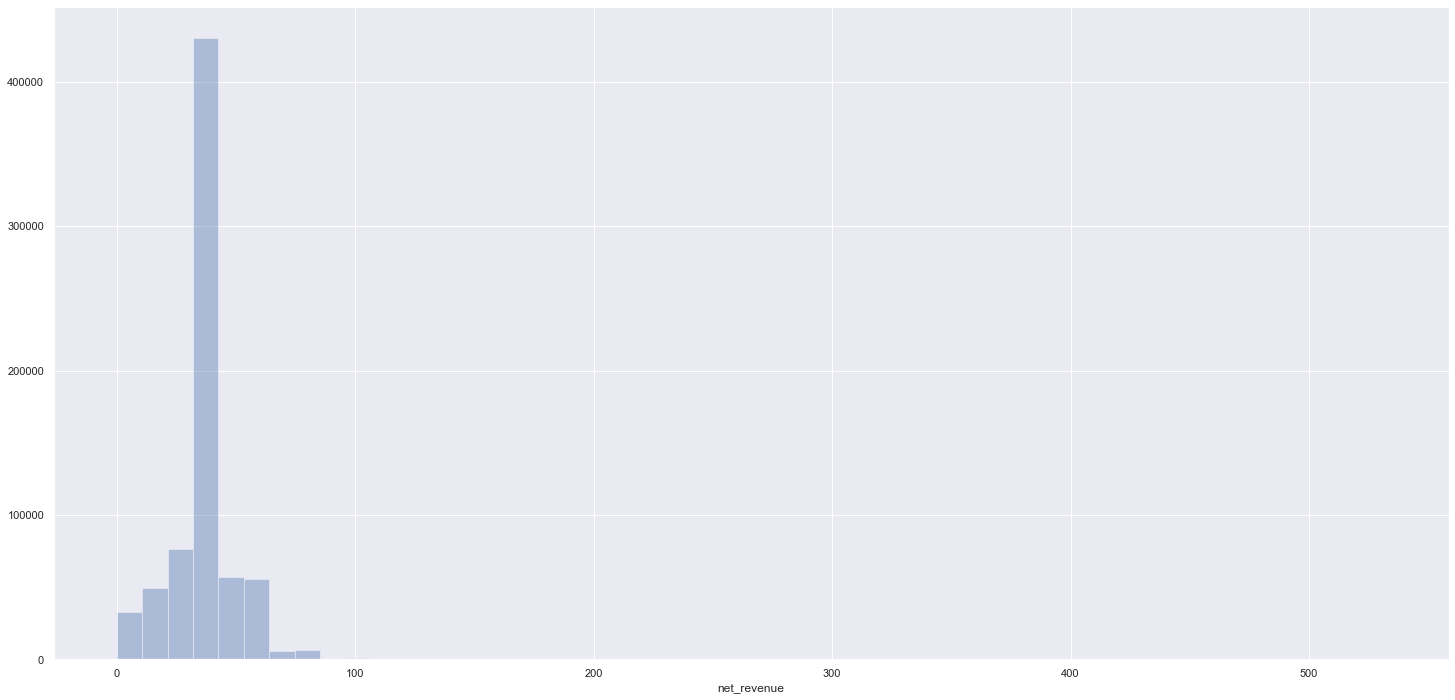

In [26]:
sns.distplot(df4['net_revenue'], kde=False)

Obs: A maioria dos algoritmos de ML foram performados com algumas condições, e uma delas, normalmente, é a curva de distribuição da variável target, de forma que quanto mais se aproxima de uma variável normal, melhor é o seu resultado.

Por isso, precisamos transformar a variável target de forma que corresponda a uma curva normal ou pelo menos tenha uma aparência semelhante.

Existem várias técnicas de transformação, como por exemplo o uso do log.

### 4.1.2 Numerical Variable

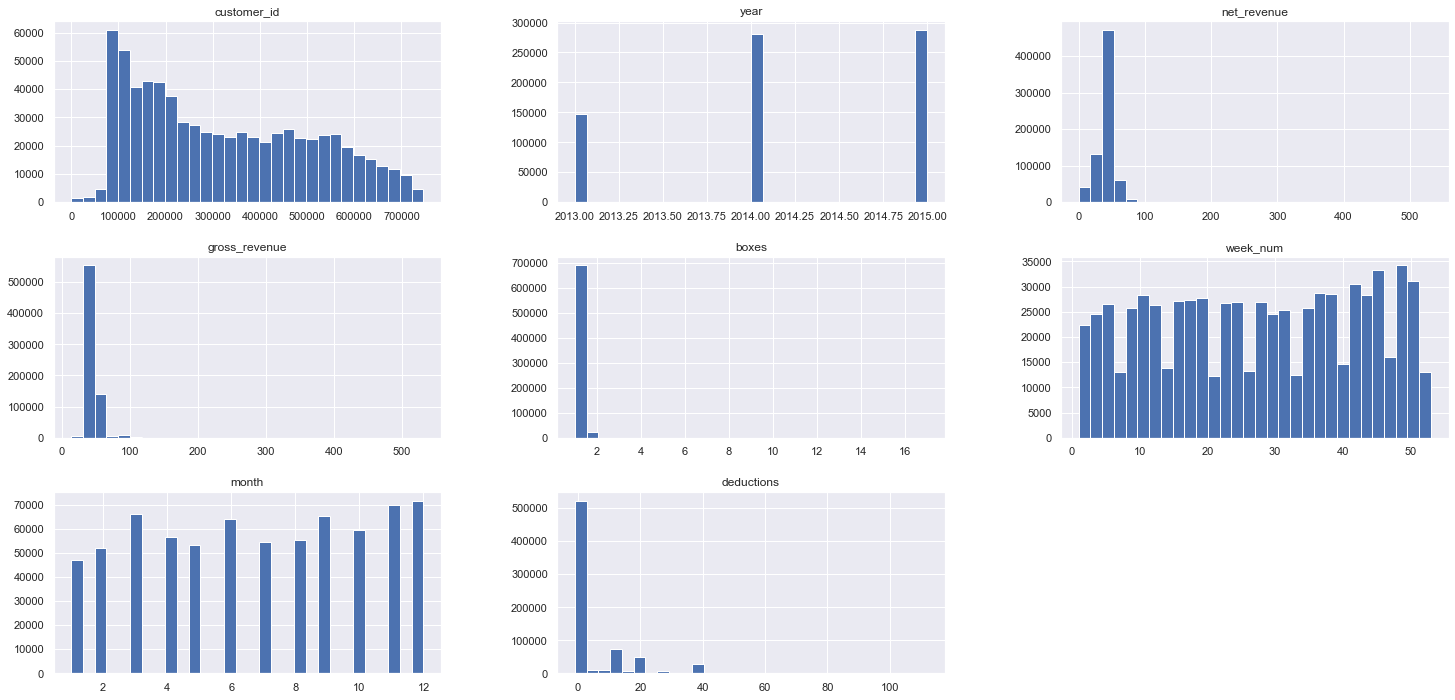

In [27]:
num_attributes.hist(bins=30);

**OBSERVAÇÕES:**
- ANO: O volume de compras aumentou ao longo dos anos
- RECEITA LÍQUIDA: Apesar de termos alguns outliers próximos a R$ 500,00, o volume de compras se concentra no valor de R$ 37,00.
- RECEITA BRUTA: A análise é semelhante a receita líquida, mas com uma média de R$ 47,00
- BOXES: Apesar de ter sido analisado na seção 1.3.2 (Data description) que os melhores resultados para receita líquida seriam dos boxes 7, 8 e 17, percebemos que o maior volume de compras está associado aos boxes 1 e 2. Nesse sentido, vale a pena entender os motivos de não serem vendidos itens dos boxes que tem maior concentração de receita e avaliar o custo-benefício de investimentos para vender mais essas categorias.
- SEMANAS: É observado que nas duas primeiras semanas há uma maior incidência de geração de receita do que nas semanas posteriores do mesmo mês.
- MESES: Aparentemente temos uma sazonalidade de 3 meses.
- DEDUÇÕES: As deduções sobre as vendas de qualquer tipo de natureza estão na média de R$ 5,00. Inclusive, seria legal observar o montante dessas deduções ao longo do tempo.


### 4.1.3 Categorical Variable

In [28]:
cat_attributes['customer_acquisition_channel'].value_counts()

Paid Marketing    562941
Referral          152934
Name: customer_acquisition_channel, dtype: int64

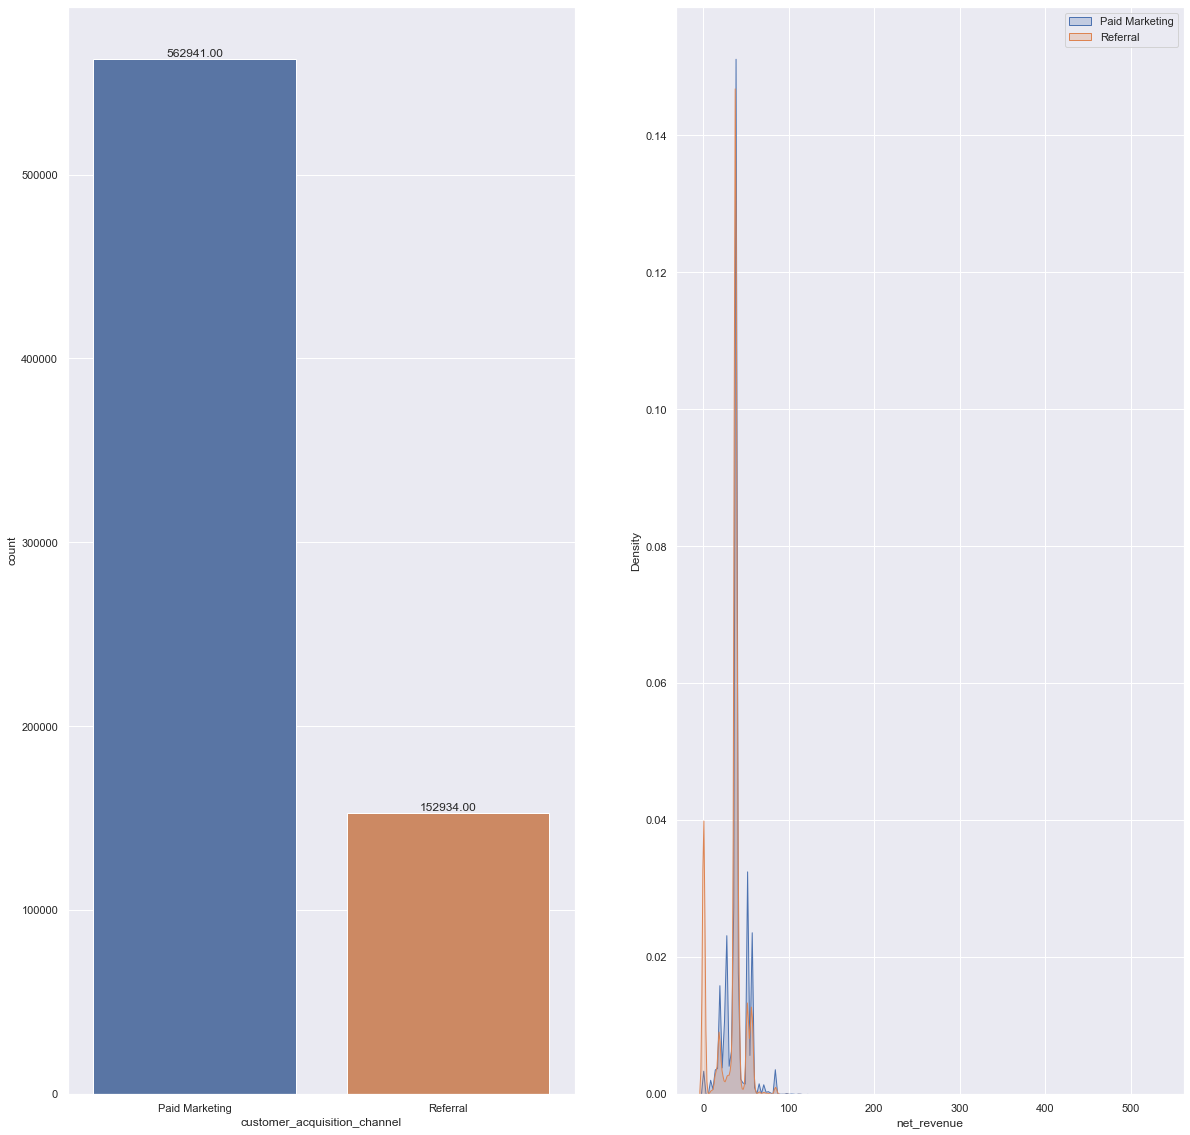

In [29]:
# Criar um grid com subplot
plt.figure(figsize=[20,20])
# State_holiday
plt.subplot(1,2,1)
a = df4.copy()
ax = sns.countplot(a['customer_acquisition_channel'])
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', 
                va = 'baseline', 
                xytext = (0,2), 
                textcoords = 'offset points')


plt.subplot(1,2,2)
sns.kdeplot(df4[df4['customer_acquisition_channel'] == 'Paid Marketing']['net_revenue'],  
            label = 'Paid Marketing', # Nome da linha
            shade = True, # Deixar mais transparente
            legend= True)

sns.kdeplot(df4[df4['customer_acquisition_channel'] == 'Referral']['net_revenue'],  
            label = 'Referral', # Nome da linha
            shade = True, # Deixar mais transparente
            legend= True)

plt.legend();


* É observado que temos uma correlação entre a receita líquida e o tipo de canal de aquisição, sendo que geralmente o marketing pago se sobressai em relação ao canal de referência.


## 4.2 Análise bivariada

### A1. Resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)

<AxesSubplot:xlabel='year'>

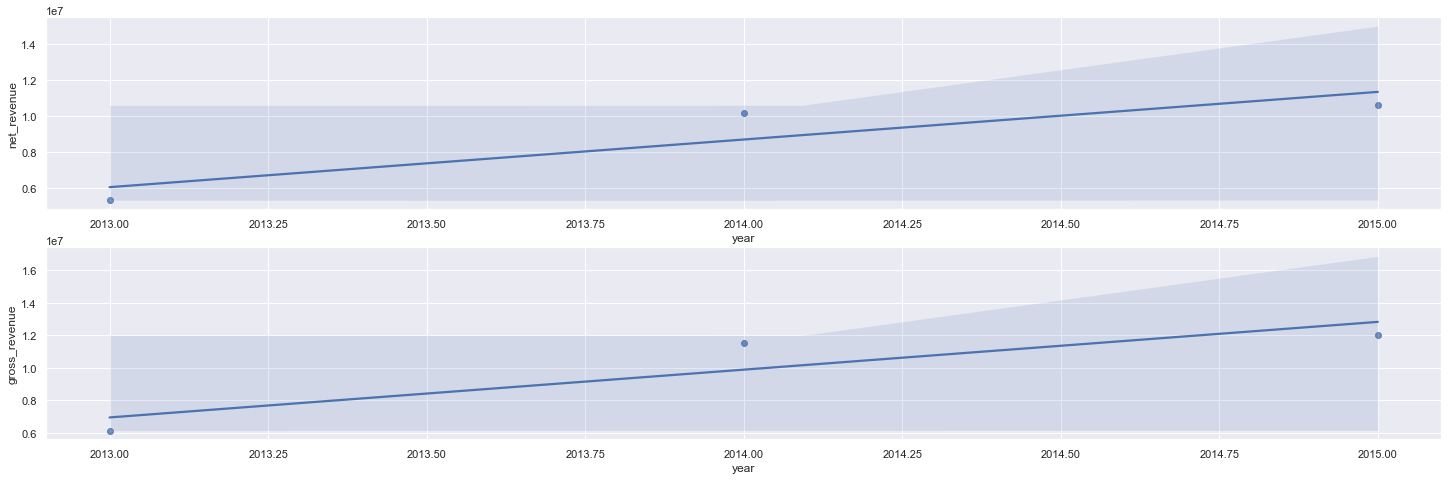

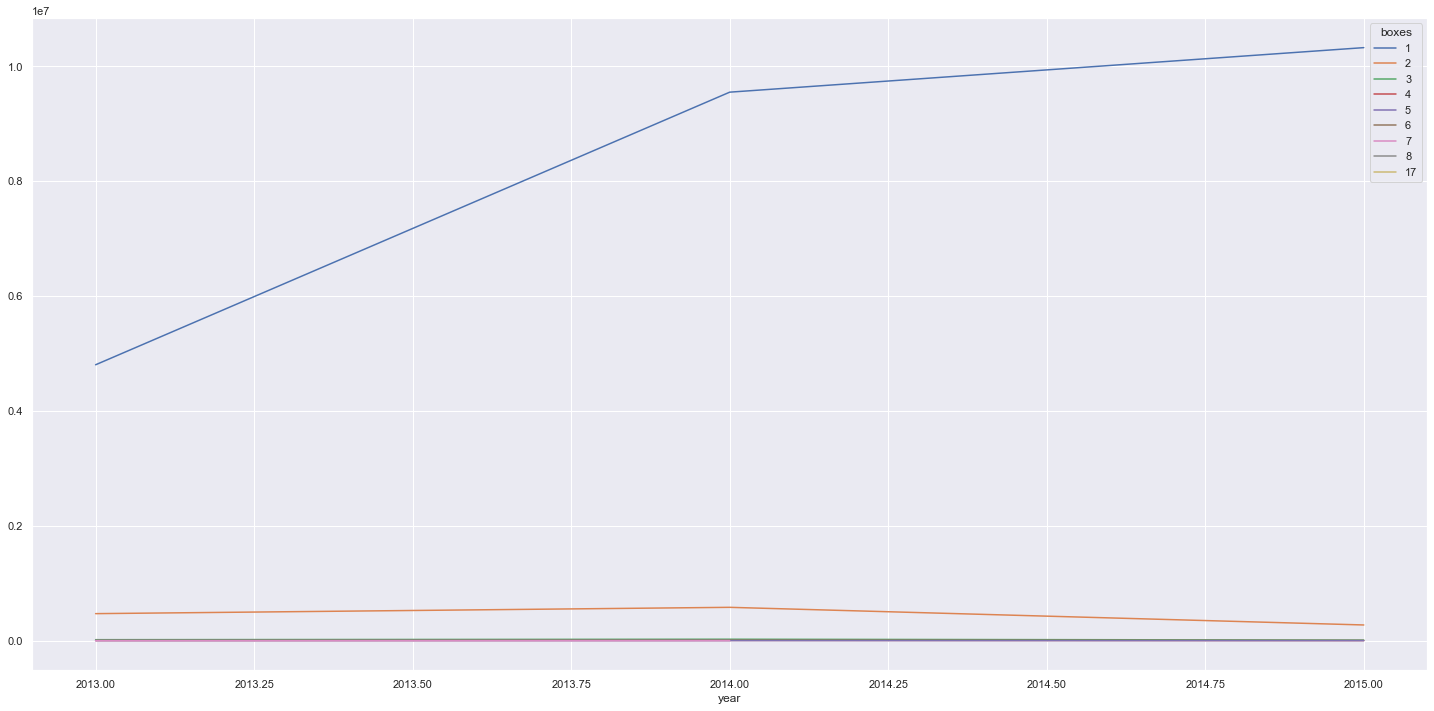

In [30]:
plt.subplot(3,1,1)
aux1 = df4[['net_revenue','gross_revenue', 'deductions','year']].groupby('year').sum().reset_index()
sns.regplot(x='year', y='net_revenue', data=aux1)

plt.subplot(3,1,2)
sns.regplot(x='year', y='gross_revenue', data=aux1)

#plt.subplot(3,1,3)
aux2 = df4[['year','boxes','net_revenue']].groupby(['year','boxes']).sum().reset_index()
aux2.pivot( index= 'year', columns= 'boxes', values= 'net_revenue').plot()


In [31]:
aux2

,year,boxes,net_revenue
0,2013,1,4803558.0
1,2013,2,470482.0
2,2013,3,17038.0
3,2013,4,2217.0
4,2013,5,1115.0
5,2013,6,303.0
6,2013,7,583.0
7,2013,17,532.0
8,2014,1,9549856.0
9,2014,2,580355.0


* O boxe 1 tem um aumento na receita ao longo dos anos, mas isso não é verdade em relação aos outros boxes.

### A2. Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?

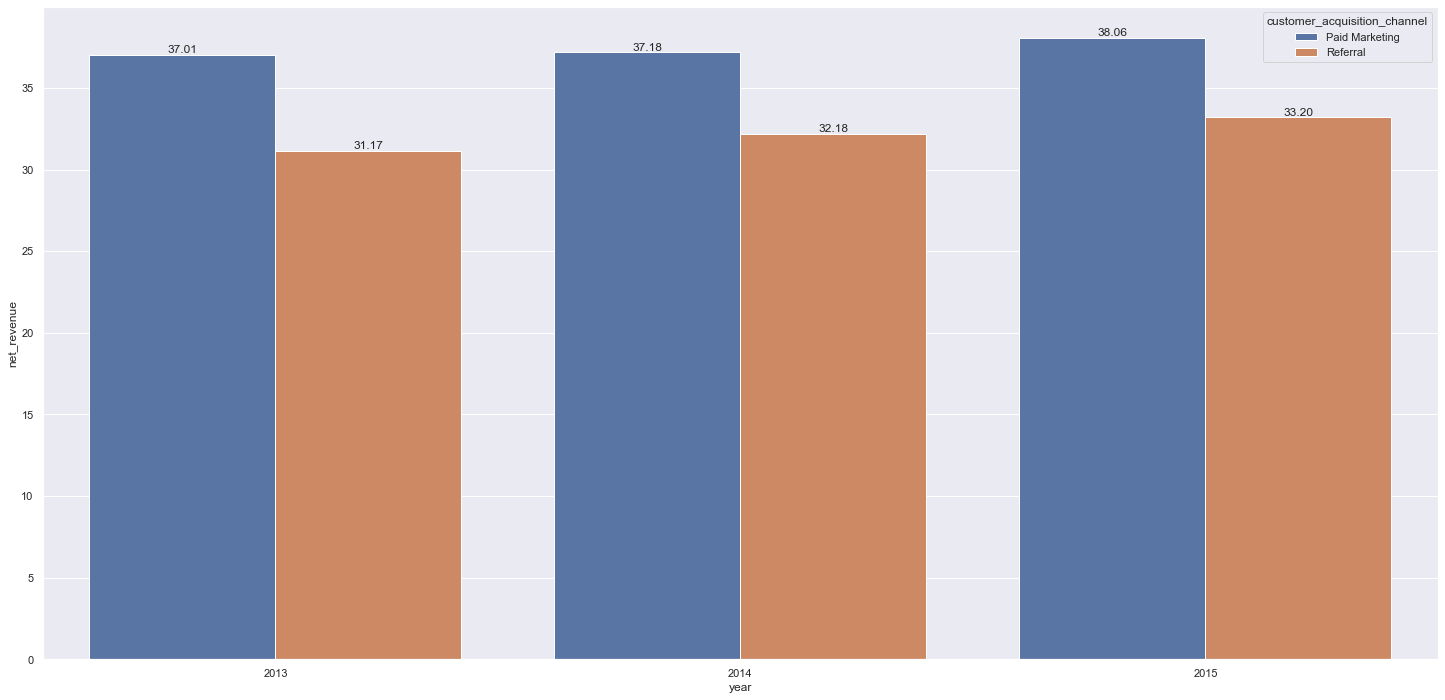

In [32]:
aux1 = df4[['net_revenue','customer_acquisition_channel','year']].groupby(['customer_acquisition_channel','year']).mean().reset_index()
cx = sns.barplot(x='year', y='net_revenue', data=aux1, hue='customer_acquisition_channel')
for p in cx.patches:
    cx.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', 
                va = 'baseline', 
                xytext = (0,2), 
                textcoords = 'offset points')

* Em todos os anos, Paid Marketing se sobressai em relação ao ticket médio da receita líquida quando comparado com o Referral.

### A3. Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)

In [33]:
df4[['customer_id', 'year']].unique()

AttributeError: 'DataFrame' object has no attribute 'unique'